## <mark>Continuous Time Markov Chains</mark>

In CTMC, the time is not discrete ($t=0,1,\ldots$) but it flows in a continuum ($ t \geq 0$).

The random process still describes the evolution of a state variable $x$ inside a discrete state space $\mathcal X$ with a graph structure.
We are given a graph $G =(\mathcal X, \Lambda)$ with nodes $\mathcal X$ and weight matrix $\Lambda$ describing possible transitions between nodes/states.

Transitions now happen at random time instants that are decided by the tick of a so called **Poisson clock**. A Poisson clock is characterized by the property that the time elapsed between any two of
its consecutive ticks is an independent random variable with exponential distribution with a specified rate.

**Remark 1**:
to simulate continuous time Markov chains the following fact will be useful.
To simulate a Poisson clock with rate $r$, one must simulate the time between two consecutive ticks, which we denote by $t_{next}$. We can compute $t_{next}$ as

$$ t_{next} = - \frac{\ln(u)}{r}$$

where $u$ is a random variable with uniform distribution, $u \in \mathcal{U}(0,1)$.


###  <span style="background-color: #00FF00">Modelling Continuous time Markov chains</span>
There are two equivalent ways of modelling CTMCs.

**1st approach**
1. you define a unique **global** Poisson clock with an appropriate rate $\omega^* = \max_i(\omega_i)$ where $\omega_i= \sum_j \Lambda_{ij}$
2. when you are at node $i$ and **the global clock ticks**, either you jump to a neighbor $j$ with probability $Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j$ or you stay in the same node (no transition) with probability $Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}$.

In this approach, the continuous time is "discretized" using a global clock, while the matrix Q describes the jumps. For this reason the matrix Q is called **jump chain** of the CTMC.

Notice that $Q_{ii}=0$ for the nodes $i$ maximizing $\omega$, and it is larger as $\omega_i/\omega$ is small.

**2nd approach**
1. each node $i$ is equipped with its own Poisson clock with rate $\omega_i= \sum_j \Lambda_{ij}$.
2. when you are at node $i$ and **the clock of that node ticks**, you jump to a neighbor $j$ with probability  $P_{ij} = \frac{\Lambda_{ij}}{\omega_i}$.

For nodes $i$ such that $\omega_i=0$ (which means that once the process in $i$ it remains $i$ forever), we need to add a selfloop $\Lambda_{ii}>0$, otherwise the matrix $P$ is not well defined.

### Example

Suppose that the weather can be modelled as a continuous-time Markov chain, with state space $\mathcal{X} = \{sunny,rainy, cloudy,snowy\}$. Let the transition rates be

![transitionRates](transitionMatrix.png)

1. The probability distribution $\bar{\pi}(t)$ of the CTMC $X(t)$ with transition rate matrix $\Lambda$ is defined as

$$
\bar{\pi}_i(t) = \mathbb P(X(t) = i), \quad i \in \mathcal X \,.
$$

It evolves according to the equation

$$
\frac{d}{dt} \bar{\pi}(t) = -L'\bar{\pi}(t)
$$

where $L= diag(w) - \Lambda$, with $w = \Lambda \mathbf{1}$.

Thus, the invariant probability vectors are eigenvector of $L'$ corresponding to eigenvalue $0$. It can also be proven that $\bar{\pi}$ is the left dominant eigenvector of $Q$, where $Q$ is the row-stochastic matrix defined as

$$
Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j \quad Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}
$$

with $\omega = \Lambda \mathbf{1}$ and $\omega_{*}=\max_i \omega_i$.

Compute the invariant probability vector $\bar{\pi}$ of the CTMC by determining the leading eigenvector of the matrix $Q'$

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Lambda = [
[0, 1/30, 1/15, 1/60],
[1/60, 0, 1/10, 1/100],
[1/25, 1/10, 0, 1/50],
[1/100, 1/10, 1/10, 0]]

w = np.sum(Lambda, axis=1)
w_star = np.max(w)
# compute the off-diagonal part of Q
Q = Lambda/w_star 
# add the diagonal part
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))

# compute dominant eigenvector
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

nstates = len(pi_bar)

pi_bar= [0.1847888  0.38682682 0.36092451 0.06745987]


2. Simulate the continuous-time Markov chain starting from sunny weather. Do this following the two different approaches:

**a)** 1st approach, i.e., using global clock with rate $\omega^* = \max_i{\omega_i}$ and the conditional probability matrix $Q$.

**b)** 2nd approach, i.e., using a rate-$\omega_i$ clock in each node $i$ and the conditional probability matrix $P$.

In both cases:
- plot the trajectory for the first 20 jumps,
- use the simulation to estimate $\bar{\pi}$.

In [ ]:
# 1st approach: global clock with rate w_star and matrix Q

Time instants:
 [  0.           4.37401874   4.66842974  10.77373158  19.55759874
  21.24578807  22.71757045  24.15648162  30.11316472  35.63794185
  43.23915907  50.2371962   51.66608525  65.36128847  68.53363505
  71.29790717  80.15965333  84.58331889  95.17821108 104.38589617]
States:
 [0 2 1 2 1 2 1 2 1 3 1 2 1 0 1 2 0 0 0 0]


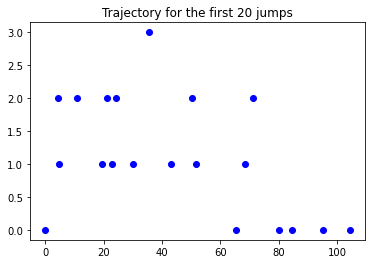

In [2]:
# set the number of steps in the simulation
n_steps = 10000
# pos will keep trace of the visited states
pos = np.zeros(n_steps, dtype=int)
# we start from state 0 (sunny)
pos[0] = 0
# transition_times will store the time instants at which
# jumps/transitions happen
transition_times = np.zeros(n_steps)
# the random time to wait for the next transition
# is drawn according to its distribution, discussed in Remark 1
# NOTE: in the formula for t_next we use w_star, the rate of the
# "global" Poisson clock
t_next = -np.log(np.random.rand())/w_star

for i in range(1,n_steps):
    # the next state to visit will be extracted according to the probabilities
    # stored in the row of Q corresponding to the current state.
    # In general, to extract a value pos[i] in (0,...,num_states-1) according to the discrete
    # distribution Q[pos[i-1],:]
    pos[i] = np.random.choice(nstates, p=Q[pos[i-1],:])
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    t_next = -np.log(np.random.rand())/w_star

# plot the trajectory for the first 20 jumps
plt.plot(transition_times[0:20], pos[0:20], 'bo')
plt.title('Trajectory for the first 20 jumps')

# print states for the first 20 time instants

print("Time instants:\n", transition_times[0:20])
print("States:\n", pos[0:20])

In [3]:
# Estimate pi

pi_estimate = np.zeros(nstates)
# We have the time instants of all transitions, we now compute time intervals.
# np.diff computes the n-th discrete difference of a vector.
# Here we set n=1 to compute first difference, which is given by 
# intervals[i] = transition_times[i+1] - transition_times[i].
# We also provide a value to  append to transition_times prior to performing the difference
# so that we can compute also the last interval: 
# transition_times[-1] + t_next is the end of the time horizon.

# print first 20 time intervals
intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)
print("Time intervals:\n", intervals[0:20])




# for each state in the state space
for state in range(nstates):
    # identify the steps when we visited that state during the process
    visits = np.argwhere(pos == state)
    # the estimate of the invariant measure for that state is equal to the
    # time spent on the state divided the total time of the process
    pi_estimate[state] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
    
print("Estimate of pi_bar:", pi_estimate)

Time intervals:
 [ 4.37401874  0.294411    6.10530184  8.78386717  1.68818933  1.47178237
  1.43891118  5.95668309  5.52477713  7.60121722  6.99803713  1.42888905
 13.69520322  3.17234658  2.76427213  8.86174615  4.42366556 10.59489219
  9.20768508  0.51510598]
Estimate of pi_bar: [0.18445859 0.38912781 0.35647906 0.06993455]


In [4]:
# 2nd approach: local clocks with rates w_i and matrix P

[[0.         0.28571429 0.57142857 0.14285714]
 [0.13157895 0.         0.78947368 0.07894737]
 [0.25       0.625      0.         0.125     ]
 [0.04761905 0.47619048 0.47619048 0.        ]]
Estimate of pi_bar: [0.15674647 0.40273685 0.37783418 0.0626825 ]


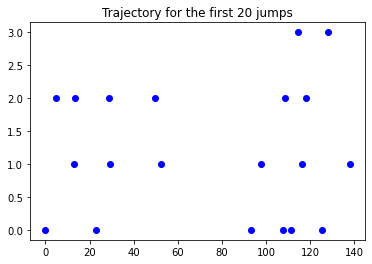

In [6]:
# contruct the P matrix (instead of Q) and clock rates w
w = np.sum(Lambda, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

# set the number of steps in the simulation
n_steps = 1000
# pos will keep trace of the visited states
pos = np.zeros(n_steps, dtype=int)
# we start from state 0
pos[0] = 0
# transition_times will store the time instants at which
# jumps/transitions happen
transition_times = np.zeros(n_steps)
# the random time to wait for the next transition
# is drawn according to its distribution, discussed in Remark 2
# NOTE: in the formula for t_next we use the rate of the clock of 
# the current state, in this case w[0].
t_next = -np.log(np.random.rand())/w[0]

for i in range(1,n_steps):
    # the next state to visit will be extracted according to the probabilities
    # stored in the row of P corresponding to the current state.
    pos[i] = np.random.choice(nstates, p=P[pos[i-1],:])
    # store the time instant of the current transition
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    # NOTE: we use the rate w[pos[i]] of the clock of the current position
    t_next = -np.log(np.random.rand())/w[pos[i]]

# plot the trajectory for the first 20 jumps
plt.plot(transition_times[0:20], pos[0:20], 'bo')
plt.title('Trajectory for the first 20 jumps')

# Estimate pi

pi_estimate = np.zeros(nstates)

intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)
for node in range(4):
    visits = np.argwhere(pos == node)
    pi_estimate[node] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
print("Estimate of pi_bar:", pi_estimate)

3. An ice-cream shop’s profit depends on the weather. Their profit per time unit is given by the following function

$$
f(X) = \begin{cases} 
10 & \text{if X = sunny}\\
2 & \text{if X = cloudy}\\
1 & \text{if X = rainy}\\
0 & \text{if X = snowy}
\end{cases}
$$

Simulate how the profit grows with time. Compute the average profit, both from the simulation and from the stationary distribution $\bar{\pi}$.

In [8]:
# Simulation of profit growth
# I choose to simulate the CTMC following the first approach

# set the number of steps in the simulation
n_steps = 1000
# payoff values corresponding to each state
payoff = [10, 2, 1, 0]

pos = np.zeros(n_steps, dtype=int)
pos[0] = 0
transition_times = np.zeros(n_steps)
# since I'm following the first simulation approach, here I divide by the rate
# w_star of the global clock
t_next = -np.log(np.random.rand())/w_star
# we define a profit variable, which stores the comulative profit up to
# the current time. For the first interval, which is t_next long, 
# the profit grows by payoff[pos[0]]*t_next
profit = payoff[pos[0]]*t_next

# we evolve the process as done before, increasing at each step the total profit
for i in range(1,n_steps):
    pos[i] = np.random.choice(nstates, p=Q[pos[i-1],:])
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    # NOTE: we use the rate w[pos[i]] of the clock of the current position
    t_next = -np.log(np.random.rand())/w_star
    # during the next interval, which is t_next long, the process will be in state
    # pos[i] and the profit will grow by payoff[pos[i]]*t_next
    profit = profit + payoff[pos[i]]*t_next
    
# the average profit is estimated as the overall profit obtained along the
# simulation divided by the total time of the process
average_profit = profit/(transition_times[-1] + t_next)
print("Average profit", average_profit)

Average profit 2.9076542111606747


Compare with the average payoff of the invariant distribution, computed as 

$$
\bar{f} = \sum_{X \in \mathcal X} f(X)\bar{\pi}_X
$$

<span style="background-color: #00FFFF">The two estimates should be equivalent as $t$ grows large because of ergodic theorem.</span>

In [9]:
print("Expected profit", sum(pi_bar*payoff))

Expected profit 2.9824661277467825


# <mark>Epidemic Models on Networks</mark>
In this section we consider a special kind of continuous time Markov chain, which is used to simulate the spread of epidemics (as well as other pairwise interacting network systems) over a network.

### <span style="background-color: #00FF00">Theory recap: Pairwise interacting network systems</span>

Consider a finite population of agents, identified with the nodes of a graph $\mathcal G = (\mathcal V, \mathcal E, W)$. 
Each agent $i \in \mathcal V$ has a state $x_i \in \mathcal A$ and all states are collected in the configuration vector $x \in \mathcal X = \mathcal A^{\mathcal V}$.

We consider an **evolution process** for the state vector $X(t)$ which is _caused by pairwise interactions between neighbouring nodes in the graph and by spontaneous mutations_.
- Each node is equipped with a Poisson clock with rate $1$. When the clock ticks, the agent is activated and it undergoes a **spontaneous mutation**.The probabilities of spontaneous mutations (conditional on the ticking of the clock) are described by the **mutation kernels**

$$
\psi^{(i)}\in\mathbb{R}^{\mathcal A\times\mathcal A}\,,\qquad  i\in\mathcal V	
$$

- Each directed link has a Poisson clock with rate $\beta W_{ij}$. When the clock ticks, the link is activated, agent $i$ meets agent $j$ and as a consequence $i$ makes a **transition**.  The transition probabilities (conditional on the ticking of the clock) are described by the **pairwise interaction kernels** ($c$ denotes state of agent $j$)

$$
\varphi^{(i,j)}(c)\in\mathbb{R}^{\mathcal A\times\mathcal A}\,,\qquad (i,j)\in\mathcal E\,,\qquad c\in\mathcal A
$$

The main models you studied during the lectures are:

$$\textbf{SI:}\qquad\psi=\left[\begin{array}{cc}1&0\\0&1\end{array}\right]\qquad\varphi(S)=\left[\begin{array}{cc}1&0\\0&1\end{array}\right]\qquad\varphi(I)=\left[\begin{array}{cc}0&1\\0&1\end{array}\right] $$


$$\textbf{SIS:}\qquad\psi=\left[\begin{array}{cc}1&0\\1&0\end{array}\right]\qquad\varphi(S)=\left[\begin{array}{cc}1&0\\0&1\end{array}\right]\qquad\varphi(I)=\left[\begin{array}{cc}0&1\\0&1\end{array}\right] $$


$$\textbf{SIR:}\qquad\psi=\left[\begin{array}{ccc}1&0&0\\0&0&1\\0&0&1\end{array}\right]\qquad\varphi(S)=\varphi(R)=\left[\begin{array}{ccc}1&0&0\\0&1&0\\0&0&1\end{array}\right]\qquad\varphi(I)=\left[\begin{array}{ccc}0&1&0\\0&1&0\\0&0&1\end{array}\right]$$
    
Given the mutation kernels and the pairwise interaction kernels, the pairwise interacting network systems are **continuous time Markov chains** with state space $\mathcal X = \mathcal A^{\mathcal V}$ and transition rates

$$
\Lambda_{x,y}=\begin{cases}
\psi^{(i)}_{x_i,y_i}+\beta\sum_jW_{ij}\varphi_{x_iy_i}^{(i,j)}(x_j) \quad \text{  if  } x_i\ne y_i\text{ and }x_{-i}=y_{-i}\\
0 \quad \text{  if  } x\text{ and }y\text{ differ in more than }1\text{ element}\,,
\end{cases}$$

**Example**: consider a complete graph with three nodes, i.e.,
$$
W = \begin{pmatrix}
0 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 0
\end{pmatrix}
$$

and consider a SI dynamics. Assume that node $1$ is infected and the other nodes are susceptible, i.e. the state $x$ is

$$
x = \begin{pmatrix}
1 \\ 0 \\ 0
\end{pmatrix}
$$

Let $y$ be the state in which also node $2$ is infected, i.e., 

$$
y = \begin{pmatrix}
1 \\ 1 \\ 0
\end{pmatrix}
$$

The transition probability from $x$ to $y$ is

$$
\Lambda_{xy} = \psi^{(2)}_{01} + \beta W_{21}\phi^{(2,1)}_{01}(1) + \beta W_{23}\phi^{(2,3)}_{01}(0).
$$

By construction, $\psi^{(i)}$ does not depend on $i$ and $\phi^{(i,j)}$ does not depend on $(i,j)$. Moreover:
- $\psi_{01}=0$, i.e., the probability of a spontaneous mutation from susceptible to infected is equal to $0$;
- $\phi_{01}(0)=0$, i.e., the probability that a susceptible agent becomes infected after meeting a susceptible agent is $0$;
- $\phi_{01}(1)=1$, i.e., the probability that a susceptible agent becomes infected after meeting an infected agent is $1$.

Then,

$$
\Lambda_{xy} = \beta W_{21} = \beta.
$$

<span style="background-color: #00AAFF">In general, in these epidemics models on simple graphs the rate at which a susceptible agents becomes infected is equal to the number of infected neighbors.<span>

## <span style="background-color: #00FF00">SI model</span>
The SI model is a pairwise interacting network system characterized by the following interaction kernels (independent of the agents):

$$
\phi(0) = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}, \quad
\phi(1) = \begin{pmatrix} 0 & 1 \\ 0 & 1 \end{pmatrix}
$$

In the SI model, each node can be either in a susceptible (denoted S or 0) or infected (denoted I or 1) state. When a susceptible node makes contact with an infected one, the contagion spreads and the susceptible node becomes infected. There are no spontaneous mutations, i.e., $\psi = I$.

### Example: SI model on a grid
In this example we consider the SI model on a $3 \times 3$ grid. We simulate the evolution of the epidemics starting from a configuration where only one node is infected and all the rest are susceptible.

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

In [3]:
from IPython.display import Markdown
def print_markdown(string):
    display(Markdown(string))
def printmd(string):
    display(Markdown(string))

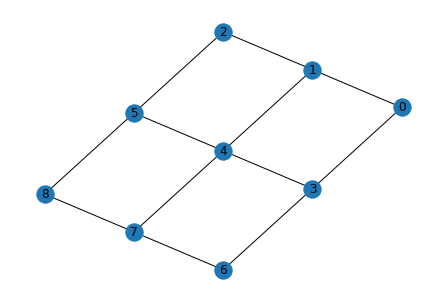

In [4]:
# Construct the graph describing interactions among agents
size = 3
# Create Grid Graph
G = nx.grid_2d_graph(size,size)

# Make node relabelling
f = dict()
for v in G.nodes:
    f[v] = v[0]*size+v[1]

G = nx.relabel_nodes(G, f)
nx.draw_spectral(G, with_labels=True)

In [5]:
# Define the Markov chain by constructing its transition matrix Lambda

In [6]:
A = {}
A['susceptible'] = 0
A['infected'] = 1
printmd("$\mathcal{A}$=")
for a in A:
    print(a + ": " + str(A[a]))

$\mathcal{A}$=

susceptible: 0
infected: 1


In [7]:
# Number of agents
n_agents = len(G)

# Pairwise interaction kernels
# 3-dimensional array
# first matrix is phi(S), second matris is phi(I)
phi = np.array([[[1,0],
                 [0,1]], 
                [[0,1],
                 [0,1]]])

printmd("$\phi(0)$=")
display(pd.DataFrame(data=phi[A['susceptible']], index=A.keys(), columns=A.keys()))
print()
printmd("$\phi(1)$=")
display(pd.DataFrame(data=phi[A['infected']], index=A.keys(), columns=A.keys()))

$\phi(0)$=

,susceptible,infected
susceptible,1,0
infected,0,1


$\phi(1)$=

,susceptible,infected
susceptible,0,1
infected,0,1


In [10]:
# Mutuation kernel
# 2-dimensional array
psi = np.identity(2,dtype=int)

printmd("$\psi$=")
display(pd.DataFrame(data=psi, index=A.keys(), columns=A.keys()))

$\psi$=

,susceptible,infected
susceptible,1,0
infected,0,1


In [27]:
# Links activation rate 
beta = 1
# Adjacency matrix
W = nx.convert_matrix.to_numpy_matrix(G)

In [28]:
import scipy as sp
# Initialize transition rates matrix
n_config = len(A)**n_agents
# need sparse matrices because n_config is very large and many elements are zeros
Lambda = sp.sparse.lil_matrix((n_config,n_config)) # initialized to all zeros


# Number of states for each agent
n_states = tuple(len(A) for _ in range(len(G)))

In [29]:
# Fill transition rates matrix
# For each configuration x, we consider all configurations y that differ only
# in the state of a single agent and we compute the rate for the admissible 
# transition x->y
for x_id in range(n_config):
    # we create states in the form (0,1,1,0,0,1,...)
    x = np.unravel_index(x_id,shape=n_states)
    x = np.array(x)
    for agent in range(n_agents):
        # for each agent, we construct the state where only the state of an agent is modified
        y = np.array(x)
        # modify state of the agent
        y[agent] = 1-y[agent]
        y_id = np.ravel_multi_index(tuple(y), dims = n_states)
        # mutation kernel is identity, so we do not consider it
        # to compute transition probabilites due to pairwise interactions, we iterate over the set of the other agents
        for other_agent in range(n_agents):
            Lambda[x_id, y_id] += beta*W[agent,other_agent]*phi[x[other_agent], x[agent], y[agent]]

printmd("$\Lambda$: " + str(n_config) + " x " + str(n_config) + " matrix")
for x in range(10):
    for y in range(n_config):
        if Lambda[x,y] != 0:
            x_s = np.array(np.unravel_index(x,shape=n_states))
            y_s = np.array(np.unravel_index(y,shape=n_states))
            printmd("$\Lambda_{x,y}$ = " + str(Lambda[x,y]))
            printmd("with $x = $")
            display(pd.DataFrame(data=['infected' if z==1 else 'susceptible' for z in x_s], index=np.arange(len(G)), columns=['state']))
            printmd("with $y = $")
            display(pd.DataFrame(data=['infected' if z==1 else 'susceptible' for z in y_s], index=np.arange(len(G)), columns=['state']))

$\Lambda$: 512 x 512 matrix

$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,infected
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,infected
6,susceptible
7,susceptible
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,infected
8,susceptible


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,infected
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,infected
8,susceptible


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,susceptible


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,infected
8,susceptible


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,infected
5,susceptible
6,susceptible
7,infected
8,susceptible


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,infected
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,infected
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,infected
6,susceptible
7,infected
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,infected
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,infected
5,susceptible
6,susceptible
7,infected
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,susceptible
8,susceptible


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,susceptible


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,susceptible
8,susceptible


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,infected
4,susceptible
5,susceptible
6,infected
7,susceptible
8,susceptible


$\Lambda_{x,y}$ = 2.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,susceptible
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,susceptible
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,infected
6,infected
7,susceptible
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,susceptible
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,infected
4,susceptible
5,susceptible
6,infected
7,susceptible
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,susceptible


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,susceptible


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,infected
5,susceptible
6,infected
7,infected
8,susceptible


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,susceptible


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,infected
4,susceptible
5,susceptible
6,infected
7,infected
8,susceptible


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,infected
6,infected
7,infected
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,infected
5,susceptible
6,infected
7,infected
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,infected
4,susceptible
5,susceptible
6,infected
7,infected
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,infected
6,susceptible
7,susceptible
8,susceptible


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,infected
6,susceptible
7,susceptible
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,infected
6,susceptible
7,susceptible
8,susceptible


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,infected
5,infected
6,susceptible
7,susceptible
8,susceptible


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,infected
6,susceptible
7,susceptible
8,susceptible


with $y = $

,state
0,susceptible
1,susceptible
2,infected
3,susceptible
4,susceptible
5,infected
6,susceptible
7,susceptible
8,susceptible


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,infected
6,susceptible
7,susceptible
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,infected
6,susceptible
7,infected
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,infected
6,susceptible
7,susceptible
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,infected
5,infected
6,susceptible
7,susceptible
8,infected


$\Lambda_{x,y}$ = 1.0

with $x = $

,state
0,susceptible
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,infected
6,susceptible
7,susceptible
8,infected


with $y = $

,state
0,susceptible
1,susceptible
2,infected
3,susceptible
4,susceptible
5,infected
6,susceptible
7,susceptible
8,infected


In [30]:
# Simulate the evolution of the epidemics

In [31]:
# Simulate the Markov chain with local clocks method
w = np.sum(Lambda, axis=1)
# reshape w in vector form
w = np.array(w.T)[0]

for x, weight in enumerate(w):
    if weight == 0:
        # add selfloop if w[x]=0, otherwise P is not well-defined
        Lambda[x,x] = 1
        w[x] = 1

D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

n_steps = 12

# store the ids of visited configurations, describing the state of each agent
states = np.zeros(n_steps, dtype=int)
# in the initial configuration, agent 0 is infected
x0 = np.zeros(n_agents, dtype=int)
x0[0]=1
# define initial state id (time 0)
states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)

transition_times = np.zeros(n_steps)
t_next = -np.log(np.random.rand())/w[0]

for i in range(1,n_steps):
    states[i] = np.random.choice(n_config, p=P[states[i-1],:])
    transition_times[i] = transition_times[i-1] + t_next
    t_next = -np.log(np.random.rand())/w[states[i]]

Jump step 0
state:


,state
0,infected
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible



Jump step 1
state:


,state
0,infected
1,infected
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible



Jump step 2
state:


,state
0,infected
1,infected
2,infected
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible



Jump step 3
state:


,state
0,infected
1,infected
2,infected
3,susceptible
4,susceptible
5,infected
6,susceptible
7,susceptible
8,susceptible



Jump step 4
state:


,state
0,infected
1,infected
2,infected
3,infected
4,susceptible
5,infected
6,susceptible
7,susceptible
8,susceptible



Jump step 5
state:


,state
0,infected
1,infected
2,infected
3,infected
4,infected
5,infected
6,susceptible
7,susceptible
8,susceptible



Jump step 6
state:


,state
0,infected
1,infected
2,infected
3,infected
4,infected
5,infected
6,infected
7,susceptible
8,susceptible



Jump step 7
state:


,state
0,infected
1,infected
2,infected
3,infected
4,infected
5,infected
6,infected
7,infected
8,susceptible



Jump step 8
state:


,state
0,infected
1,infected
2,infected
3,infected
4,infected
5,infected
6,infected
7,infected
8,infected



Jump step 9
state:


,state
0,infected
1,infected
2,infected
3,infected
4,infected
5,infected
6,infected
7,infected
8,infected



Jump step 10
state:


,state
0,infected
1,infected
2,infected
3,infected
4,infected
5,infected
6,infected
7,infected
8,infected



Jump step 11
state:


,state
0,infected
1,infected
2,infected
3,infected
4,infected
5,infected
6,infected
7,infected
8,infected


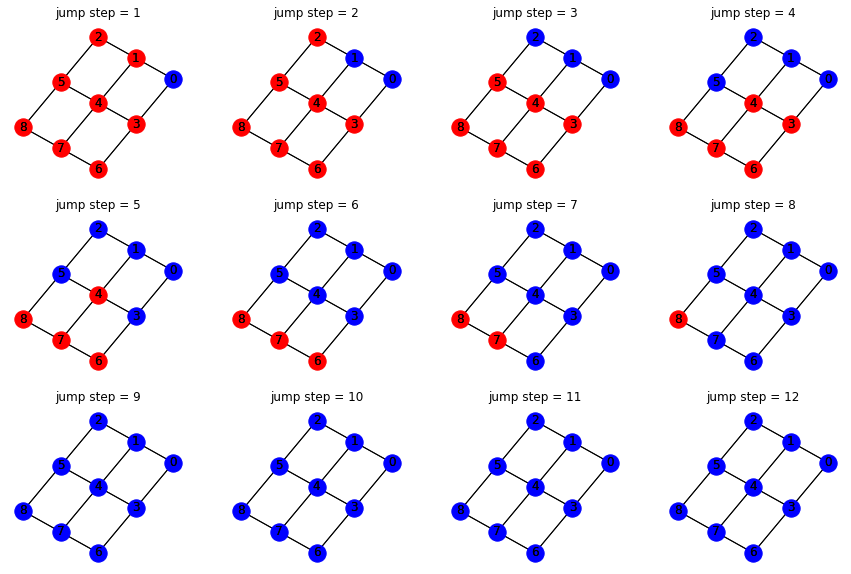

In [35]:
# Plot the infection spread

import matplotlib.pyplot as plt

pos = nx.spectral_layout(G)
fig = plt.figure(figsize=(15,10))
for t in range(0,n_steps):
    plt.subplot(3,4,t+1)
    x_id = states[t]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    print("Jump step " + str(t))
    print("state:")
    A_rev = dict((v,k) for k,v in A.items())
    display(pd.DataFrame(data=[A_rev[z] for z in x], index=np.arange(len(G)), columns=['state']))
    print()
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')
    plt.title('jump step = {0}'.format(t+1))

**<span style="background-color: #00AAFF">Remark</span>**: we simulated the evolution of the epidemics by exploiting the general simulation method for continuous time Markov chains. This is totally correct, and it is the easiest way to understand and learn the process, but it requires **precomputing the transition matrix** $\Lambda$, which is then used to perform the simulation. Computing the whole $\Lambda$ has a large computational cost, and it becomes practically unfeasable when the number of agents grows. To have a better idea, try to repeat the previous simulation on a $4 \times 4$ or $5 \times 5$ grid, and see how the computational time blows up. Indeed, the number of states is $2^{n}$, i.e., it grows exponentially in $n$.

To overcome this issue, a more efficient simulation method is proposed below, which may turn useful if you need to deal with larger networks or more complicated models (e.g., SIR dynamics, in which the number of states is $3^{n}$). Instead of precomputing the transition matrix $\Lambda$, it computes its rows along the way when needed. In particular, when the process is at some configuration $x$, row $x$ of $\Lambda$ is computed, used to compute the probabilities of transitions from $x$ and to pick the next visited configuration.

Try again to simulate the SI model on a $4 \times 4$ grid with this method to appreciate the computational saving.

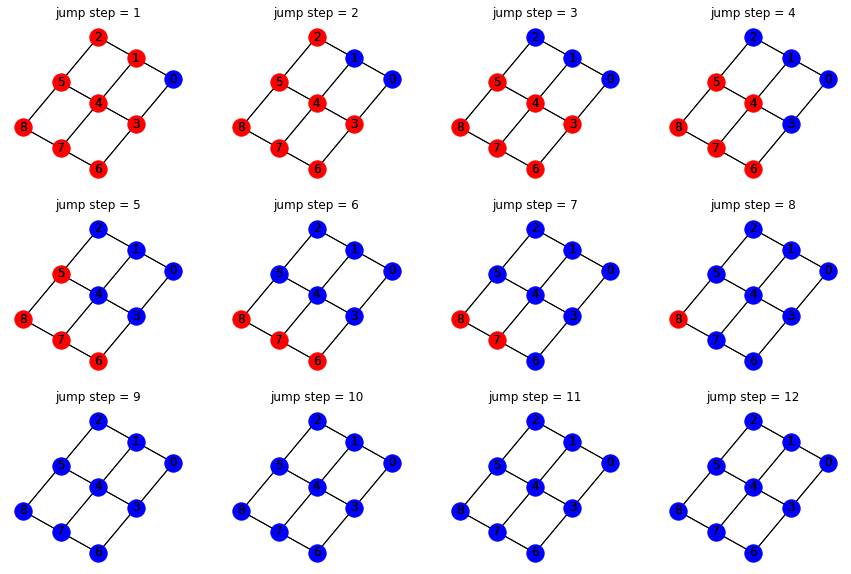

In [36]:
# Simulation with local clocks method
# In this variant, the matrix Lambda is not precomputed
# We just compute the jump chain without taking into account the transition times, but this can be generalized as done before

# in the initial configuration, agent 0 is infected
x0 = np.zeros(n_agents, dtype=int)
x0[0]=1
# define initial state id (time 0)
states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)

# for each step of the simulation
for i in range(1,n_steps):
    # consider the current configuration
    x = np.unravel_index(states[i-1],shape=n_states)
    x = np.array(x)
    # define a list of admissible destination configurations, 
    # and the rates of the corresponding transitions
    destinations = list()
    transition_rates = list()
    # admissible destinations differ from the current configuration
    # for the state of a single agent
    for agent in range(n_agents):
        # construct an admissible destination and append it to the list
        y = np.array(x)
        y[agent] = 1-y[agent]
        y_id = np.ravel_multi_index(tuple(y), dims = n_states)
        destinations.append(y_id)
        # compute the transition rate from x to y
        rate = 0
        for other_agent in range(n_agents):
            # for every other_agent in the network, compute its contribution to the rate of the transition of the agent
            rate += beta*W[agent,other_agent]*phi[x[other_agent], x[agent], y[agent]]
        transition_rates.append(rate)
    # given all transition rates from x to admissible y
    # compute w_x, the clock rate of configuration x
    # Notice: transition_rates is the x-th row of Lambda
    transition_rates = np.array(transition_rates)
    w_x = np.sum(transition_rates)
    # if w_x = 0, then the process stays in x
    if w_x == 0:
        states[i] = states[i-1]
    # else, transition probabilities are computed as transition_rates/w_x
    # and the next config is chosen accordingly.
    # Notice: this is the x-th row of P
    else:
        probabilities = transition_rates / w_x
        states[i] = np.random.choice(destinations, p=probabilities)
        
# Plot the infection spread
pos = nx.spectral_layout(G)
fig = plt.figure(figsize=(15,10))
for t in range(0,n_steps):
    plt.subplot(3,4,t+1)
    x_id = states[t]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    nx.draw_spectral(G,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
    nx.draw_spectral(G,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')
    plt.title('jump step = {0}'.format(t+1))

## <span style="background-color: #00FF00">SIS model</span>
The SIS model is a pairwise interacting network system characterized by the following interaction kernels (independent of the agents):

$$
\phi(0) = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}, \quad
\phi(1) = \begin{pmatrix} 0 & 1 \\ 0 & 1 \end{pmatrix}
$$

and the following mutuation kernel (independent of the agents):

$$
\psi = \begin{pmatrix} 1 & 0 \\ 1 & 0 \end{pmatrix}
$$

In the SI model, each node can be either in a susceptible (denoted S or 0) or infected (denoted I or 1) state. When a susceptible node makes contact with an infected one, the contagion spreads and the susceptible node becomes infected. There is a spontaneous mutations, which happens when the node is in an infected state.

### Example: SIS model on a grid
In this example we consider the SIS model on a $3 \times 3$ grid. We simulate the evolution of the epidemics starting from a configuration where only one node is infected and all the rest are susceptible.

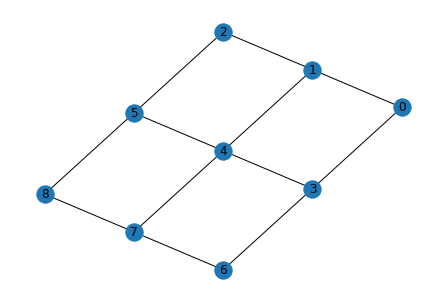

In [11]:
# Construct the graph describing interactions among agents
size = 3
# Create Grid Graph
G = nx.grid_2d_graph(size,size)

# Make node relabelling
f = dict()
for v in G.nodes:
    f[v] = v[0]*size+v[1]

G = nx.relabel_nodes(G, f)
nx.draw_spectral(G, with_labels=True)

In [12]:
# Define the Markov and simulate the evolution of the epidemics

In [13]:
A = {}
A['susceptible'] = 0
A['infected'] = 1
printmd("$\mathcal{A}$=")
for a in A:
    print(a + ": " + str(A[a]))

$\mathcal{A}$=

susceptible: 0
infected: 1


In [14]:
# Number of agents
n_agents = len(G)

# Pairwise interaction kernels
# 3-dimensional array
# first matrix is phi(S), second matris is phi(I)
phi = np.array([[[1,0],
                 [0,1]], 
                [[0,1],
                 [0,1]]])

printmd("$\phi(0)$=")
display(pd.DataFrame(data=phi[A['susceptible']], index=A.keys(), columns=A.keys()))
print()
printmd("$\phi(1)$=")
display(pd.DataFrame(data=phi[A['infected']], index=A.keys(), columns=A.keys()))

$\phi(0)$=

,susceptible,infected
susceptible,1,0
infected,0,1


$\phi(1)$=

,susceptible,infected
susceptible,0,1
infected,0,1


In [15]:
# Mutuation kernel
# 2-dimensional array
psi = np.array([[1,0],[1,0]])

printmd("$\psi$=")
display(pd.DataFrame(data=psi, index=A.keys(), columns=A.keys()))

$\psi$=

,susceptible,infected
susceptible,1,0
infected,1,0


In [19]:
n_config = len(A)**n_agents

# Links activation rate 
beta = 1
# Adjacency matrix
W = nx.convert_matrix.to_numpy_matrix(G)

# Number of states for each agent
n_states = tuple(len(A) for _ in range(len(G)))

In [43]:
# Simulation with local clocks method
# matrix Lambda is not precomputed

n_steps = 12
# store the ids of visited configurations, describing the state of each agent
states = np.zeros(n_steps, dtype=int)
# in the initial configuration, agent 0 is infected
x0 = np.zeros(n_agents, dtype=int)
x0[0]=1
# define initial state id (time 0)
states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
transition_times = np.zeros(n_steps)

# for each step of the simulation
for i in range(1,n_steps):
    # consider the current configuration
    x = np.unravel_index(states[i-1],shape=n_states)
    x = np.array(x)
    # define a list of admissible destination configurations, 
    # and the rates of the corresponding transitions
    destinations = list()
    transition_rates = list()
    # admissible destinations differ from the current configuration
    # for the state of a single agent
    for agent in range(n_agents):
        # construct an admissible destination and append it to the list
        y = np.array(x)
        y[agent] = 1-y[agent]
        y_id = np.ravel_multi_index(tuple(y), dims = n_states)
        destinations.append(y_id)
        # compute the transition rate from x to y
        # rate initialized to the contribution due to the possible mutation of the agent
        rate = psi[x[agent], y[agent]]
        for other_agent in range(n_agents):
            # for every other_agent in the network, compute its contribution to the rate of the transition of the agent
            rate += beta*W[agent,other_agent]*phi[x[other_agent], x[agent], y[agent]]
        transition_rates.append(rate)
    # given all transition rates from x to admissible y
    # compute w_x, the clock rate of configuration x
    # Notice: transition_rates is the x-th row of Lambda
    transition_rates = np.array(transition_rates)
    w_x = np.sum(transition_rates)
    # if w_x = 0, then the process stays in x
    if w_x == 0:
        states[i] = states[i-1]
        w_x = 1
    # else, transition probabilities are computed as transition_rates/w_x
    # and the next config is chosen accordingly.
    # Notice: this is the x-th row of P
    else:
        probabilities = transition_rates / w_x
        states[i] = np.random.choice(destinations, p=probabilities)
    t_next = -np.log(np.random.rand())/w_x
    transition_times[i] = transition_times[i-1] + t_next

Jump step 0
state:


,state
0,infected
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible



Jump step 1
state:


,state
0,infected
1,susceptible
2,susceptible
3,infected
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible



Jump step 2
state:


,state
0,infected
1,infected
2,susceptible
3,infected
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible



Jump step 3
state:


,state
0,infected
1,infected
2,susceptible
3,infected
4,infected
5,susceptible
6,susceptible
7,susceptible
8,susceptible



Jump step 4
state:


,state
0,infected
1,infected
2,susceptible
3,infected
4,infected
5,susceptible
6,susceptible
7,infected
8,susceptible



Jump step 5
state:


,state
0,infected
1,infected
2,susceptible
3,infected
4,susceptible
5,susceptible
6,susceptible
7,infected
8,susceptible



Jump step 6
state:


,state
0,infected
1,infected
2,susceptible
3,infected
4,susceptible
5,susceptible
6,infected
7,infected
8,susceptible



Jump step 7
state:


,state
0,susceptible
1,infected
2,susceptible
3,infected
4,susceptible
5,susceptible
6,infected
7,infected
8,susceptible



Jump step 8
state:


,state
0,infected
1,infected
2,susceptible
3,infected
4,susceptible
5,susceptible
6,infected
7,infected
8,susceptible



Jump step 9
state:


,state
0,infected
1,infected
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,susceptible



Jump step 10
state:


,state
0,infected
1,infected
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,infected
7,infected
8,infected



Jump step 11
state:


,state
0,infected
1,infected
2,susceptible
3,susceptible
4,infected
5,susceptible
6,infected
7,infected
8,infected


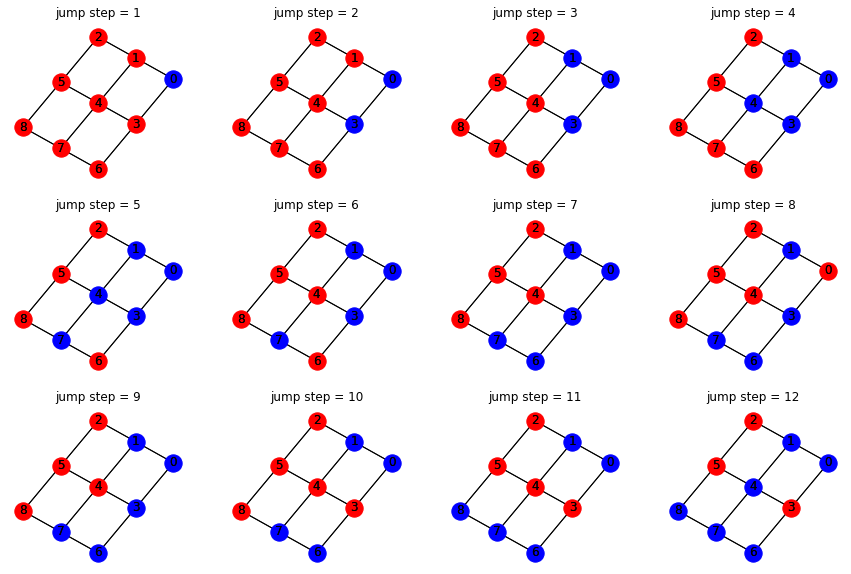

In [44]:
import matplotlib.pyplot as plt

# Plot the infection spread

pos = nx.spectral_layout(G)
fig = plt.figure(figsize=(15,10))
for t in range(0,n_steps):
    plt.subplot(3,4,t+1)
    x_id = states[t]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    print("Jump step " + str(t))
    print("state:")
    A_rev = dict((v,k) for k,v in A.items())
    display(pd.DataFrame(data=[A_rev[z] for z in x], index=np.arange(len(G)), columns=['state']))
    print()
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')
    plt.title('jump step = {0}'.format(t+1))

## <span style="background-color: #00FF00">SIR model</span>
The SIR model is a pairwise interacting network system characterized by the following interaction kernels (independent of the agents):

$$
\phi(0) = \phi(2) = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix}, \quad
\phi(1) = \begin{pmatrix} 0 & 1 & 0\\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix}
$$

and the following mutuation kernel (independent of the agents):

$$
\psi = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 0 & 1 \\ 0 & 0 & 1 \end{pmatrix}
$$

In the SIR model, each node can be in a susceptible (denoted S or 0), infected (denoted I or 1) or recovered (denoted R or 2) state. When a susceptible node makes contact with an infected one, the contagion spreads and the susceptible node becomes infected. The same does not happen with a recovered node. There is a spontaneous mutations, which happens when the node is in an infected state: it becomes recovered.

### Example: SIR model on a grid
In this example we consider the SIR model on a $3 \times 3$ grid. We simulate the evolution of the epidemics starting from a configuration where only one node is infected and all the rest are susceptible.

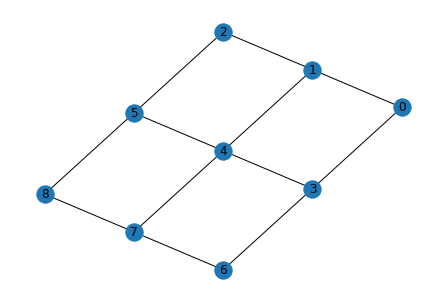

In [45]:
# Construct the graph describing interactions among agents
size = 3
# Create Grid Graph
G = nx.grid_2d_graph(size,size)

# Make node relabelling
f = dict()
for v in G.nodes:
    f[v] = v[0]*size+v[1]

G = nx.relabel_nodes(G, f)
nx.draw_spectral(G, with_labels=True)

In [46]:
# Define the Markov and simulate the evolution of the epidemics

In [47]:
A = {}
A['susceptible'] = 0
A['infected'] = 1
A['recovered'] = 2
printmd("$\mathcal{A}$=")
for a in A:
    print(a + ": " + str(A[a]))

$\mathcal{A}$=

susceptible: 0
infected: 1
recovered: 2


In [48]:
# Number of agents
n_agents = len(G)

# Pairwise interaction kernels
# 3-dimensional array
# first matrix is phi(S), second matris is phi(I), third matrix is phi(R)
phi = np.array([[[1,0,0],
                 [0,1,0],
                 [0,0,1]], 
                [[0,1,0],
                 [0,1,0],
                 [0,0,1]],
                [[1,0,0],
                 [0,1,0],
                 [0,0,1]]])

printmd("$\phi(0)$=")
display(pd.DataFrame(data=phi[A['susceptible']], index=A.keys(), columns=A.keys()))
print()
printmd("$\phi(1)$=")
display(pd.DataFrame(data=phi[A['infected']], index=A.keys(), columns=A.keys()))
print()
printmd("$\phi(2)$=")
display(pd.DataFrame(data=phi[A['recovered']], index=A.keys(), columns=A.keys()))

$\phi(0)$=

,susceptible,infected,recovered
susceptible,1,0,0
infected,0,1,0
recovered,0,0,1


$\phi(1)$=

,susceptible,infected,recovered
susceptible,0,1,0
infected,0,1,0
recovered,0,0,1


$\phi(2)$=

,susceptible,infected,recovered
susceptible,1,0,0
infected,0,1,0
recovered,0,0,1


In [49]:
# Mutuation kernel
# 2-dimensional array
psi = np.array([[1,0,0],[0,0,1],[0,0,1]])

printmd("$\psi$=")
display(pd.DataFrame(data=psi, index=A.keys(), columns=A.keys()))

$\psi$=

,susceptible,infected,recovered
susceptible,1,0,0
infected,0,0,1
recovered,0,0,1


In [53]:
n_config = len(A)**n_agents

# Links activation rate 
beta = 1
# Adjacency matrix
W = nx.convert_matrix.to_numpy_matrix(G)

# Number of states for each agent
n_states = tuple(len(A) for _ in range(len(G)))

In [54]:
# Simulation with local clocks method
# matrix Lambda is not precomputed



# Convert n from base 10 to base n
# It returns the number as a string
def baseb(n, b):
    e = n//b
    q = n%b
    if n == 0:
        return '0'
    elif e == 0:
        return str(q)
    else:
        return baseb(e, b) + str(q)

    
    
    
n_steps = 12
# store the ids of visited configurations, describing the state of each agent
states = np.zeros(n_steps, dtype=int)
# in the initial configuration, agent 0 is infected
x0 = np.zeros(n_agents, dtype=int)
x0[0]=1
# define initial state id (time 0)
states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
transition_times = np.zeros(n_steps)

# for each step of the simulation
for i in range(1,n_steps):
    # consider the current configuration
    x = np.unravel_index(states[i-1],shape=n_states)
    x = np.array(x)
    # define a list of admissible destination configurations, 
    # and the rates of the corresponding transitions
    destinations = list()
    transition_rates = list()
    # admissible destinations differ from the current configuration
    # for the state of a single agent
    for agent in range(n_agents):
        # construct an admissible destination and append it to the list (1st possibility)
        y = np.array(x)
        y[agent] = y[agent]+1
        y[agent] = int(baseb(y[agent],3)[-1])
        y_id = np.ravel_multi_index(tuple(y), dims = n_states)
        destinations.append(y_id)
        # compute the transition rate from x to y
        # rate initialized to the contribution due to the possible mutation of the agent
        rate = psi[x[agent], y[agent]]
        for other_agent in range(n_agents):
            # for every other_agent in the network, compute its contribution to the rate of the transition of the agent
            rate += beta*W[agent,other_agent]*phi[x[other_agent], x[agent], y[agent]]
        transition_rates.append(rate)
    for agent in range(n_agents):
        # construct an admissible destination and append it to the list (2nd possibility)
        z = np.array(x)
        z[agent] = z[agent]+2
        z[agent] = int(baseb(z[agent],3)[-1])
        z_id = np.ravel_multi_index(tuple(z), dims = n_states)
        destinations.append(z_id)
        # compute the transition rate from x to z
        # rate initialized to the contribution due to the possible mutation of the agent
        rate = psi[x[agent], z[agent]]
        for other_agent in range(n_agents):
            # for every other_agent in the network, compute its contribution to the rate of the transition of the agent
            rate += beta*W[agent,other_agent]*phi[x[other_agent], x[agent], z[agent]]
        transition_rates.append(rate)
    # given all transition rates from x to admissible y or z
    # compute w_x, the clock rate of configuration x
    # Notice: transition_rates is the x-th row of Lambda
    transition_rates = np.array(transition_rates)
    w_x = np.sum(transition_rates)
    # if w_x = 0, then the process stays in x
    if w_x == 0:
        states[i] = states[i-1]
        w_x = 1
    # else, transition probabilities are computed as transition_rates/w_x
    # and the next config is chosen accordingly.
    # Notice: this is the x-th row of P
    else:
        probabilities = transition_rates / w_x
        states[i] = np.random.choice(destinations, p=probabilities)
    t_next = -np.log(np.random.rand())/w_x
    transition_times[i] = transition_times[i-1] + t_next

Jump step 0
state:


,state
0,infected
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible



Jump step 1
state:


,state
0,infected
1,susceptible
2,susceptible
3,infected
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible



Jump step 2
state:


,state
0,infected
1,susceptible
2,susceptible
3,recovered
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible



Jump step 3
state:


,state
0,infected
1,infected
2,susceptible
3,recovered
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible



Jump step 4
state:


,state
0,infected
1,infected
2,susceptible
3,recovered
4,infected
5,susceptible
6,susceptible
7,susceptible
8,susceptible



Jump step 5
state:


,state
0,infected
1,infected
2,susceptible
3,recovered
4,infected
5,infected
6,susceptible
7,susceptible
8,susceptible



Jump step 6
state:


,state
0,infected
1,infected
2,susceptible
3,recovered
4,infected
5,recovered
6,susceptible
7,susceptible
8,susceptible



Jump step 7
state:


,state
0,recovered
1,infected
2,susceptible
3,recovered
4,infected
5,recovered
6,susceptible
7,susceptible
8,susceptible



Jump step 8
state:


,state
0,recovered
1,recovered
2,susceptible
3,recovered
4,infected
5,recovered
6,susceptible
7,susceptible
8,susceptible



Jump step 9
state:


,state
0,recovered
1,recovered
2,susceptible
3,recovered
4,infected
5,recovered
6,susceptible
7,infected
8,susceptible



Jump step 10
state:


,state
0,recovered
1,recovered
2,susceptible
3,recovered
4,infected
5,recovered
6,susceptible
7,infected
8,infected



Jump step 11
state:


,state
0,recovered
1,recovered
2,susceptible
3,recovered
4,infected
5,recovered
6,susceptible
7,recovered
8,infected


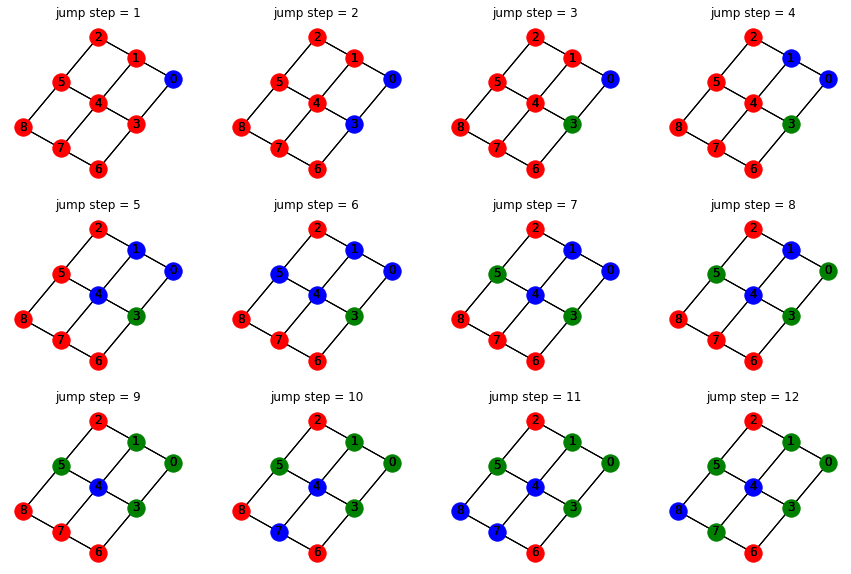

In [60]:
import matplotlib.pyplot as plt

# Plot the infection spread

pos = nx.spectral_layout(G)
fig = plt.figure(figsize=(15,10))
for t in range(0,n_steps):
    plt.subplot(3,4,t+1)
    x_id = states[t]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    print("Jump step " + str(t))
    print("state:")
    A_rev = dict((v,k) for k,v in A.items())
    display(pd.DataFrame(data=[A_rev[z] for z in x], index=np.arange(len(G)), columns=['state']))
    print()
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==2).T[0].tolist(),
        node_color = 'g')
    plt.title('jump step = {0}'.format(t+1))

### <span style="background-color: #DC143C">Theoretical questions on pairwise interacting network systems</span>
- what is the hitting time to the absorbing states;
- when multiple absorbing states exist, what are the absorbing probabilities?

**SI**: only one absorbing state where all the nodes are infected, i.e., $\mathbf{1}$.

**SIS**: only one absorbing state, where all the nodes are susceptible, i.e., $0 \mathbf{1}$.

**SIR**: all the states with no infected are absorbing.   

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Note: When $\mathcal{S}$ trapping: hitting probabilities $\rightarrow$ absorbing probabilities

In some special cases, it is possible to answer analitically to this kind of questions. 

### <span style="background-color: #9ACD32">Macroscopic variables</span>

Typically, we are not interested in the state of the single nodes, but we are interested in some macroscopic variables that describes the state of the system. Let us define for an undirected graph the following quantities:

$$
N(x) = \mathbf{1}'x = \sum_{i\in \mathcal{V}} x_i \quad \text{and} \quad B(x) = \sum_{i,j \in \mathcal{V}} W_{ij}(1-x_i)x_j = \sum_{i:x_i=0} \sum_{j:x_j=1} W_{ij}.
$$

- $N(x)$ is the number of infected nodes in the configuration $x$.
- $B(x)$ is the active boundary, which in simple graphs is the number of links between agents with state 0 and agents with state 1 (susceptible and infected agents in epidemic models).

We can describe the evolution of $N(t)\equiv N(X(t))$ as a function of $N(t)$ and $B(t)\equiv B(X(t))$. $N(t)$ may either increase or decrease, i.e., if there is a transition at time $t$, then $N(t^+)=N(t^-)+1$ or $N(t^+)=N(t^-)-1$. This kind of arguments are useful for every binary dynamics, i.e., dynamics with two states. For a given configuration $x$ with $N(x)=k$ and general pairwise dynamics, the rate at which $N(x)$ increases to $k+1$ is

\begin{align*}
	\Lambda_{k,k+1} = \sum_{i:x_i=0} \Lambda_{x,x+\delta^{(i)}} &= \sum_{i:x_i=0} \left( \psi_{01} + \beta \sum_{j} W_{ij} \varphi_{01}(x_j)\right) \\
	&= \sum_{i:x_i=0} \psi_{01} + \sum_{i:x_i=0} \beta \sum_{j:x_j=1} W_{ij} \varphi_{01}(1) \\
	&= \underbrace{(n-N(x))}_{\substack{\text{n. of nodes} \\ \text{in state 0}}} \psi_{01} + \underbrace{B(x)}_{\substack{\text{n. of links $(i,j)$} \\ \text{s.t. $x_i=0$, $x_j=1$}}} \beta \varphi_{01}(1).
\end{align*}

($n$ is the total number of nodes.)      

In the third equality we have used the assumption that $\varphi_{01}(0) = 0$, i.e., more in general if an agent $i$ in state $a$ meets another agent in the state $a$, the agent $i$ does not modify her state.

The rate at which $N(x)$ decreases to $N(x)-1$ is given by

\begin{align*}
	\Lambda_{k,k-1} = \sum_{i:x_i=1} \Lambda_{x,x-\delta^{(i)}} &= \sum_{i:x_i=1} \left( \psi_{10} + \beta \sum_{j} W_{ij} \varphi_{10}(x_j)\right) \\
	&= \sum_{i:x_i=1} \psi_{10} + \sum_{i:x_i=1} \beta \sum_{j:x_j=0} W_{ij} \varphi_{10}(0) \\
	&= \underbrace{N(x)}_{\substack{\text{n of nodes} \\ \text{in state 1}}} \psi_{10} + \underbrace{B(x)}_{\substack{\text{n of links $(i,j)$} \\ \text{s.t. $x_i=1$, $x_j=0$}}} \beta \varphi_{10}(0).
\end{align*}

**Remark**: $N(X(t))$ is not a Markovian process in general.   

Indeed, the rates depend on $N(x)$ but also on $B(X(t))$, thus it is not possible to describe the evolution of $N(X(t))$ without knowing $X(t)$. However, if we analyze an application whereby $B(x)$ is a function of $N(x)$, then the rate depends only on $N(x)$.   

Thus, in this case, $N(X(t))$ is Markovian, and in particular it is a birth-and-death Markov chain. An example is the complete graph, where $B(x)=N(x) (n-N(x))$. Another example is the line graph for the SI dynamics when a node at the end of the line is infected. Notice however that this is no longer true for the SIS dynamics.

**Note**: Birth and death chains

Random walks on weighted line graphs: at every time step the position can only increase or decrease by 1 or remain still.

![birthAndDeathChain](birthAndDeath.png)

$\mathcal{V} = \{0,1,..n\}$, $P_{i,i+1} = p_i$, $P_{i,i-1} = q_i$, $P_{i,i} = r_i$

## <span style="background-color: #FFA500">Extinction time in SIS dynamics on complete graph.</span>
We are given a complete graph with $n$ nodes. 


For the complete graph, the boundary $B(x)$ is function of $N(x)$, in particular $B(x)=N(x) \cdot (n-N(x))$. Thus, since the evolution of $N(t)\equiv N(X(t))$ depends only on $N(t)$, this means that we can describe the evolution of the process by looking only at $N(x)$ instead of the state of the single nodes.     

The evolution of $N(t)\equiv N(X(t))$ is described by a birth-and-death Markov chain.

For the SIS dynamics, $\psi_{01}=0, \psi_{10}=1, \phi_{10}(0)=0, \phi_{01}(1)=1$.


Thus:
- the upward transition rate is 
	$$
    \Lambda_{k,k+1} = \beta k(n-k)
    $$

- the downward transition rate is 
$$
\Lambda_{k,k-1} = k
$$

We thus have a continuous-time birth-and-death process for $N(t)$.

Let $\tau_i$ indicate the expected time such that there are no infected nodes, assuming that $N(0)=i$.

By using the theory of birth-and-death processes, we obtain that

$$
\begin{cases}
\tau_0 = 0 \\
\tau_k = \frac{1}{k+\beta k (n-k)} + \frac{k}{k+\beta k (n-k)}\tau_{k+1} + \frac{\beta k (n-k)}{k + \beta k (n-k)}\tau_{k-1}, \quad 0<k<n \\
\tau_n = \frac{1}{n} + \frac{\tau_{n-1}}{n}.
\end{cases}
$$

Let $\alpha = \beta n$. By some computations (see the lecture nodes for details) one can observe that

- if $\alpha < 1$, then

$$
\tau_n \sim \frac{\log n}{1-\alpha}.
$$

- If $\alpha>1$, then for every $\gamma \in [1/\alpha, 1]$

$$
\tau_1 \ge \frac{(\alpha \gamma)^{(1-\gamma)n}}{\gamma \alpha n}.
$$

Notice that $\alpha$ indicates the expected number of infected that an infected produces in a fully susceptible agents network. There is a phase transition:

- if $\alpha<1$, the extinction time from the fully infected state scales with $\log n$;
- if $\alpha>1$, the extinction time, even from a single infected, grows exponentially in $n$.

Observe that if $\alpha<1$ the expected fraction of infected decreases in time, whereas if $\alpha>1$ the expected fraction of infected increases.

Thus, if $\alpha>1$, the epidemic can be eradicated only due to stochastic fluctuations.

**Exercise 1**: implement the SIS dynamics in a complete graph, and verify the phase transition for the eradication time in a large complete graph.

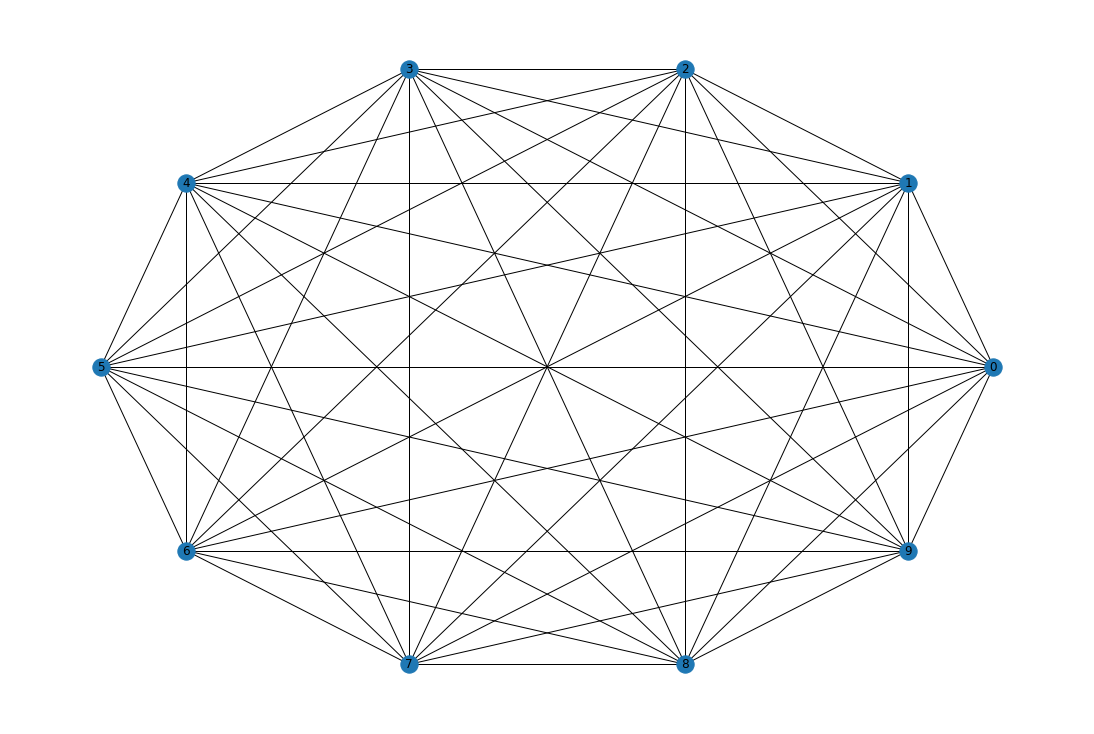

In [79]:
# Construct the graph describing interactions among agents
G = nx.complete_graph(10)

plt.figure(figsize=(15,10))
nx.draw(G, pos=nx.circular_layout(G), with_labels=True)

In [80]:
A = {}
A['susceptible'] = 0
A['infected'] = 1

n_agents = len(G)

phi = np.array([[[1,0],
                 [0,1]], 
                [[0,1],
                 [0,1]]])

psi = np.array([[1,0],[1,0]])

n_config = len(A)**n_agents

beta = 1

W = nx.convert_matrix.to_numpy_matrix(G)

n_states = tuple(len(A) for _ in range(len(G)))

In [81]:
# Simulation with local clocks method
# matrix Lambda is not precomputed

n_steps = 12
# store the ids of visited configurations, describing the state of each agent
states = np.zeros(n_steps, dtype=int)
# in the initial configuration, agent 0 is infected
x0 = np.zeros(n_agents, dtype=int)
x0[0]=1
# define initial state id (time 0)
states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
transition_times = np.zeros(n_steps)

# for each step of the simulation
for i in range(1,n_steps):
    # consider the current configuration
    x = np.unravel_index(states[i-1],shape=n_states)
    x = np.array(x)
    # define a list of admissible destination configurations, 
    # and the rates of the corresponding transitions
    destinations = list()
    transition_rates = list()
    # admissible destinations differ from the current configuration
    # for the state of a single agent
    for agent in range(n_agents):
        # construct an admissible destination and append it to the list
        y = np.array(x)
        y[agent] = 1-y[agent]
        y_id = np.ravel_multi_index(tuple(y), dims = n_states)
        destinations.append(y_id)
        # compute the transition rate from x to y
        # rate initialized to the contribution due to the possible mutation of the agent
        rate = psi[x[agent], y[agent]]
        for other_agent in range(n_agents):
            # for every other_agent in the network, compute its contribution to the rate of the transition of the agent
            rate += beta*W[agent,other_agent]*phi[x[other_agent], x[agent], y[agent]]
        transition_rates.append(rate)
    # given all transition rates from x to admissible y
    # compute w_x, the clock rate of configuration x
    # Notice: transition_rates is the x-th row of Lambda
    transition_rates = np.array(transition_rates)
    w_x = np.sum(transition_rates)
    # if w_x = 0, then the process stays in x
    if w_x == 0:
        states[i] = states[i-1]
        w_x = 1
    # else, transition probabilities are computed as transition_rates/w_x
    # and the next config is chosen accordingly.
    # Notice: this is the x-th row of P
    else:
        probabilities = transition_rates / w_x
        states[i] = np.random.choice(destinations, p=probabilities)
    t_next = -np.log(np.random.rand())/w_x
    transition_times[i] = transition_times[i-1] + t_next

Jump step 0
state:


,state
0,infected
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 1
state:


,state
0,infected
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,infected
8,susceptible
9,susceptible



Jump step 2
state:


,state
0,infected
1,susceptible
2,infected
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,infected
8,susceptible
9,susceptible



Jump step 3
state:


,state
0,infected
1,susceptible
2,infected
3,infected
4,susceptible
5,susceptible
6,susceptible
7,infected
8,susceptible
9,susceptible



Jump step 4
state:


,state
0,infected
1,susceptible
2,infected
3,infected
4,susceptible
5,susceptible
6,susceptible
7,infected
8,infected
9,susceptible



Jump step 5
state:


,state
0,infected
1,susceptible
2,infected
3,infected
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,infected
9,susceptible



Jump step 6
state:


,state
0,infected
1,susceptible
2,infected
3,infected
4,infected
5,susceptible
6,susceptible
7,susceptible
8,infected
9,susceptible



Jump step 7
state:


,state
0,infected
1,susceptible
2,infected
3,infected
4,infected
5,susceptible
6,infected
7,susceptible
8,infected
9,susceptible



Jump step 8
state:


,state
0,infected
1,susceptible
2,infected
3,infected
4,infected
5,susceptible
6,infected
7,susceptible
8,susceptible
9,susceptible



Jump step 9
state:


,state
0,infected
1,susceptible
2,infected
3,infected
4,infected
5,susceptible
6,infected
7,susceptible
8,susceptible
9,infected



Jump step 10
state:


,state
0,infected
1,infected
2,infected
3,infected
4,infected
5,susceptible
6,infected
7,susceptible
8,susceptible
9,infected



Jump step 11
state:


,state
0,infected
1,infected
2,infected
3,infected
4,infected
5,susceptible
6,infected
7,infected
8,susceptible
9,infected


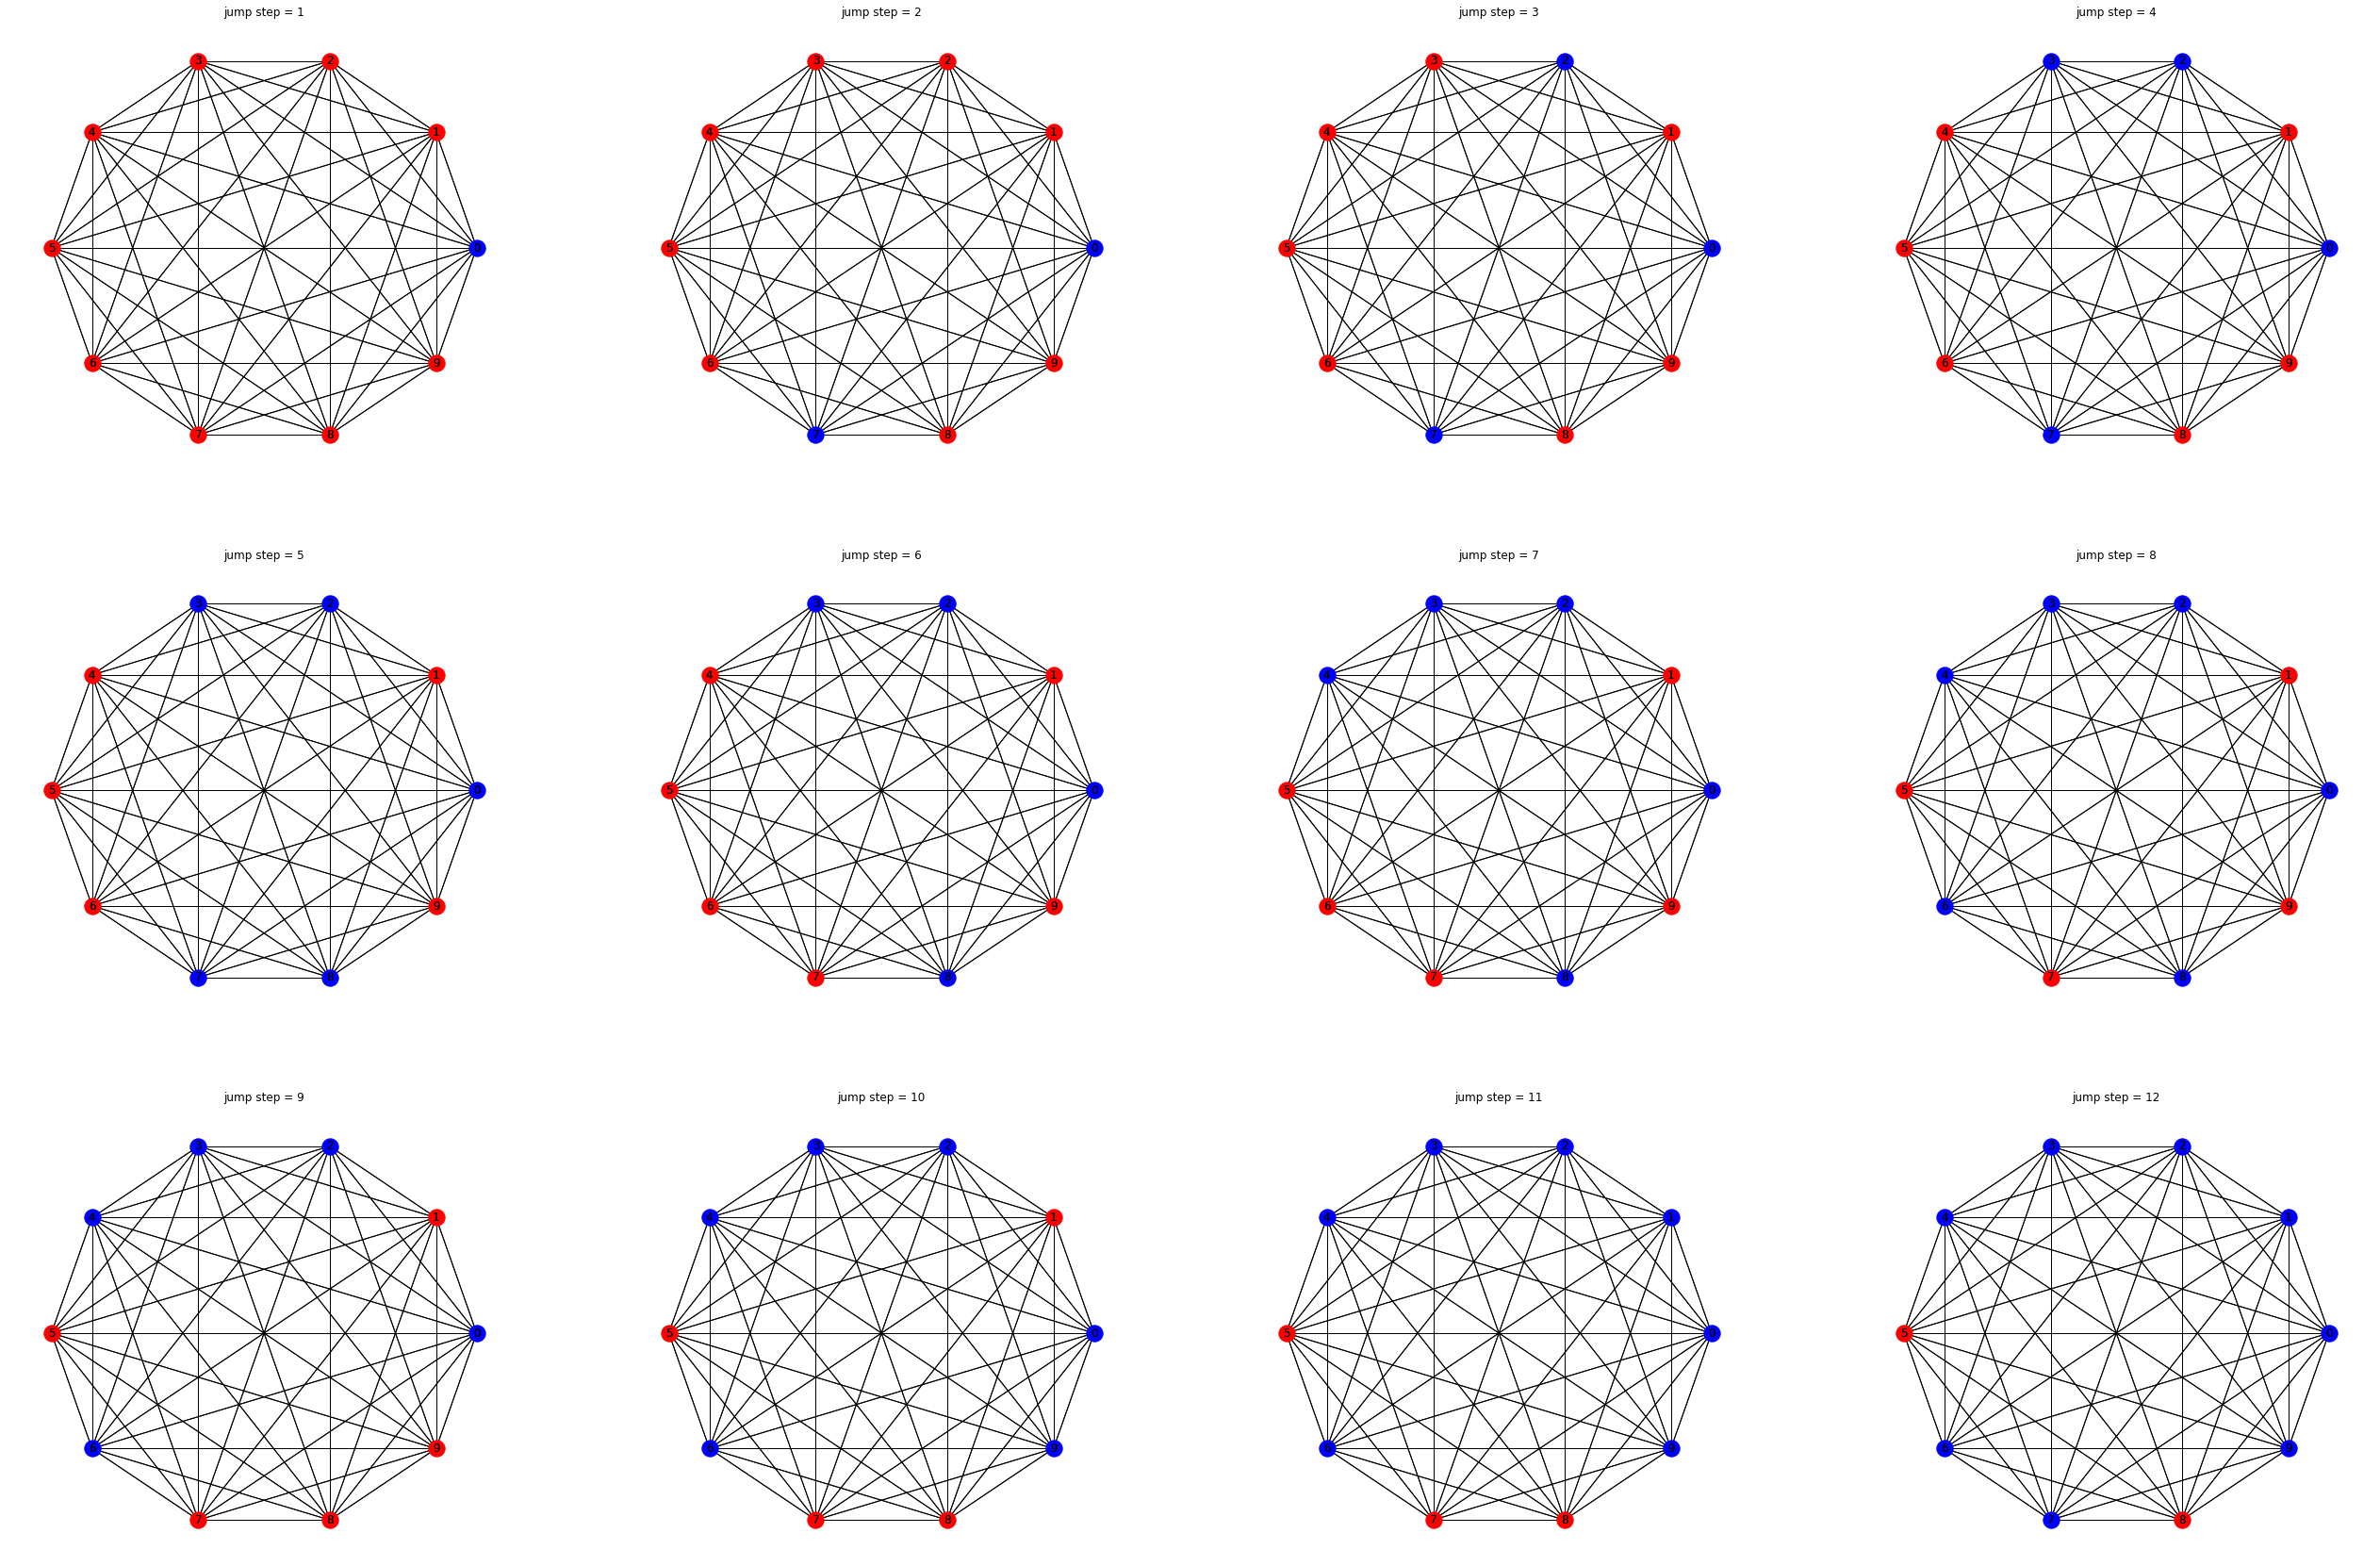

In [84]:
import matplotlib.pyplot as plt

# Plot the infection spread

pos = nx.circular_layout(G)
fig = plt.figure(figsize=(45,30))
for t in range(0,n_steps):
    plt.subplot(3,4,t+1)
    x_id = states[t]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    print("Jump step " + str(t))
    print("state:")
    A_rev = dict((v,k) for k,v in A.items())
    display(pd.DataFrame(data=[A_rev[z] for z in x], index=np.arange(len(G)), columns=['state']))
    print()
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')
    plt.title('jump step = {0}'.format(t+1))

## <span style="background-color: #FFA500">Fixation probability for evolutionary dynamics on undirected graphs</span>

In **evolutionary graph dynamics** the states belong to a finite set of species $\mathcal{A}$ (let us consider binary dynamics, i.e., $\mathcal{A}$ contains only two species). 

To every specie $a\in\mathcal A$ a **fitness parameter** $f_a\in(0,1]$ is associated. There are no spontaneous mutations. On the other hand, the specie $X_i(t)$ present in node $i$ at time $t$ gets replaced by the specie $X_j(t)$ currently present in node $j$ at rate $W_{ij}f_{X_j(t)}$. We can fit this in our pairwise interacting network systems by defining the pairwise interaction kernels  as 

$$\varphi^{(i,j)}(c)=(1-f_c)I+f_c\mathbf{1}(\delta^{(c)})^T\,,\qquad (i,j)\in\mathcal E\,,\quad c\in\mathcal A$$

Observe that, if all species have unitary fitness, i.e., if $f_a=1$ for all $a$ in $\mathcal A$, then the evolutionary dynamics coincide with the voter model. 

Let us consider a binary evolutionary dynamics on an **undirected graph** $G$ with two species only: 
- a native specie $0$ with fitness $f_0$, and
- a mutant specie $1$ with fitness $f_1$.  

Denote by $\rho=f_1/f_0$ the relative fitness of the mutant specie with respect to the native one. We are interested in computing the **fixation probability**, i.e., the probability that only mutants survive while the native specie eventually gets extinct, when starting with an initial configuration comprising a positive but typically small number of mutants. In this case,

$$\varphi_{01}(1) = f_1, \quad \varphi_{10}(0)=f_0$$. 

$N(X(t))$ denotes the number of agents of specie 1 given the configuration $X(t)$. Since the graph is undirected and $\psi_{01}=\psi_{10}=0$, it follows that:

- the upward drift is $\Lambda_{k,k+1} = \beta B(X(t)) f_1$
- the downward drift is $\Lambda_{k,k-1} = \beta B(X(t)) f_0$.

Since we do not have any information on the graph structure, we cannot write $B(X(t))$  explicitly. However, since we are interested in the fixation probabilities and not in hitting times, we can study the associated jump chain. The following remark is useful.

**Remark: multiple Poisson clocks**. Suppose that there are $n$ Poisson clocks with rates $\lambda_1,\cdots,\lambda_n$. Then, the probability of $i$ being the first ticking clock is

$$
\frac{\lambda_i}{\sum_{j}\lambda_j}.
$$

As a consequence, the increasing and the decreasing probabilities in the associated jump chain are

$$
P_{k,k+1} = \frac{\beta B(X(t))f_1}{\beta B(X(t))f_0 + \beta B(X(t))f_1} = \frac{\rho}{1+\rho}.
$$

$$P_{k,k-1} = \frac{1}{1+\rho}.$$ 

and the ratio between the increasing and the decreasing probabilities in the associated jump chain is $\rho$, independently of the state $x(t)$.

Therefore, the fixation probability for the evolutionary dynamics on a connected undirected graph of size $n$ coincides with the probability that the birth-and-death chain with transition probabilities as above reaches state $n$ before state $0$ that was computed in the lecture notes. In particular,

$$
\mathbf{P} \left(\lim_{t\to+\infty}X(t)=\mathbf{1}|X(0)\right) = \frac{1-\rho^{-N(0)}}{1-\rho^{-n}}.$$

**Remark**: For this special dynamics, even without information on the graph, it was possible to describe the evolution of $N(t)$ by a birth-and-death Markov chain.

In the next subsection we shall see that even for non-binary dynamics the analysis of the dynamics may be sometimes simplified if we are able to describe properly the dynamics.

## <span style="background-color: #FFA500">Absorbing probabilities in SIR dynamics on a ring graph</span>

In SIR dynamics there are multiple absorbing states (every disease-free state is absorbing). Eventually, the Markov process will reach a disease-free state with probability 1. Instead of computing the absorbing time for a disease-free state, we here ask for every $k \le n$ what is the probability that the Markov process is absorbed in a state with $n-k$ susceptible agents and $k$ recovered agents. This indicates how large the outbreak was.

Let us work with a ring graph, and assume that only one node is infected at the initial time.

Jump step 0
state:


,state
0,infected
1,susceptible
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 1
state:


,state
0,infected
1,infected
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 2
state:


,state
0,infected
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 3
state:


,state
0,infected
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 4
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 5
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 6
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 7
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 8
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 9
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 10
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 11
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 12
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 13
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 14
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 15
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 16
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 17
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 18
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 19
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 20
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 21
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 22
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible



Jump step 23
state:


,state
0,recovered
1,recovered
2,susceptible
3,susceptible
4,susceptible
5,susceptible
6,susceptible
7,susceptible
8,susceptible
9,susceptible


<Figure size 1080x720 with 0 Axes>

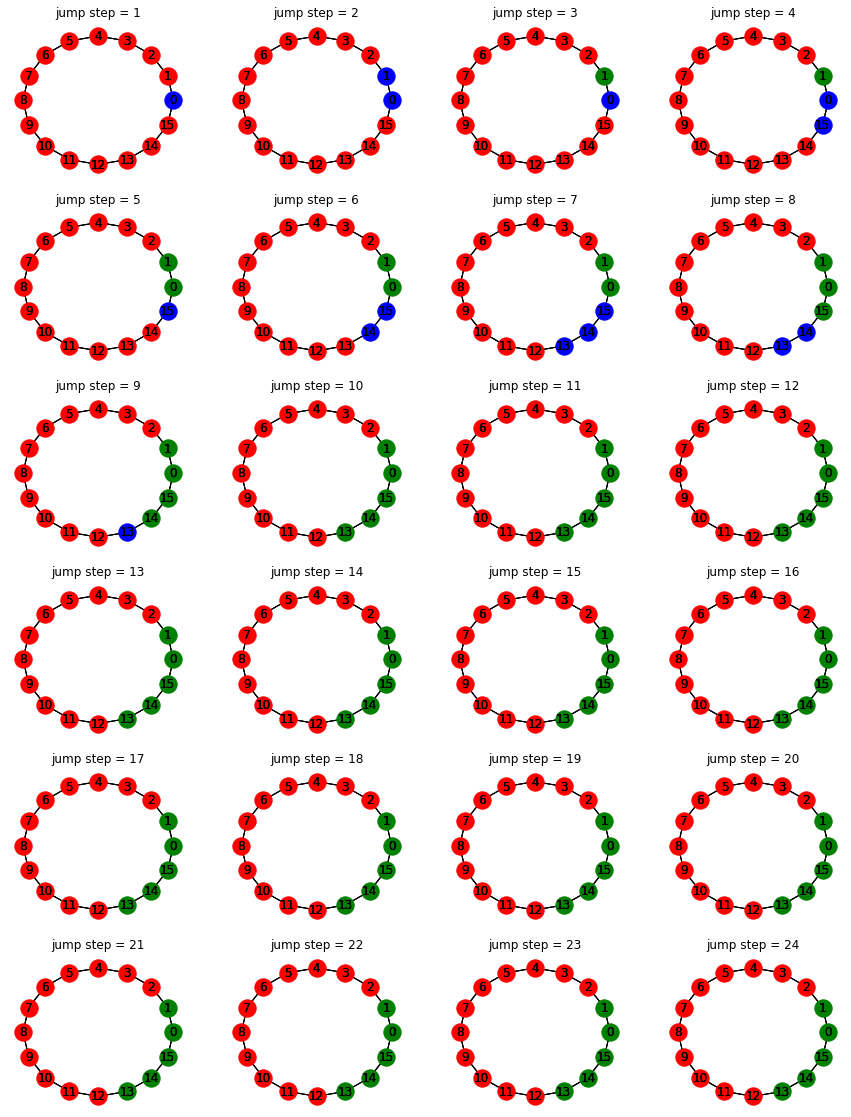

In [24]:
# Example:

G = nx.Graph()
size = 15
for i in range(size):
    G.add_edge(i,i+1)
G.add_edge(size,0)
plt.figure(figsize=(15,10))
pos=nx.circular_layout(G)

A = {}
A['susceptible'] = 0
A['infected'] = 1
A['recovered'] = 2
    
n_agents = len(G)

phi = np.array([[[1,0,0],
                 [0,1,0],
                 [0,0,1]], 
                [[0,1,0],
                 [0,1,0],
                 [0,0,1]],
                [[1,0,0],
                 [0,1,0],
                 [0,0,1]]])

psi = np.array([[1,0,0],[0,0,1],[0,0,1]])

n_config = len(A)**n_agents

beta = 1
W = nx.convert_matrix.to_numpy_matrix(G)

n_states = tuple(len(A) for _ in range(len(G)))

def baseb(n, b):
    e = n//b
    q = n%b
    if n == 0:
        return '0'
    elif e == 0:
        return str(q)
    else:
        return baseb(e, b) + str(q)

    
    
    
n_steps = 24
# store the ids of visited configurations, describing the state of each agent
states = np.zeros(n_steps, dtype=int)
# in the initial configuration, agent 0 is infected
x0 = np.zeros(n_agents, dtype=int)
x0[0]=1
# define initial state id (time 0)
states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
transition_times = np.zeros(n_steps)

# for each step of the simulation
for i in range(1,n_steps):
    # consider the current configuration
    x = np.unravel_index(states[i-1],shape=n_states)
    x = np.array(x)
    # define a list of admissible destination configurations, 
    # and the rates of the corresponding transitions
    destinations = list()
    transition_rates = list()
    # admissible destinations differ from the current configuration
    # for the state of a single agent
    for agent in range(n_agents):
        # construct an admissible destination and append it to the list (1st possibility)
        y = np.array(x)
        y[agent] = y[agent]+1
        y[agent] = int(baseb(y[agent],3)[-1])
        y_id = np.ravel_multi_index(tuple(y), dims = n_states)
        destinations.append(y_id)
        # compute the transition rate from x to y
        # rate initialized to the contribution due to the possible mutation of the agent
        rate = psi[x[agent], y[agent]]
        for other_agent in range(n_agents):
            # for every other_agent in the network, compute its contribution to the rate of the transition of the agent
            rate += beta*W[agent,other_agent]*phi[x[other_agent], x[agent], y[agent]]
        transition_rates.append(rate)
    for agent in range(n_agents):
        # construct an admissible destination and append it to the list (2nd possibility)
        z = np.array(x)
        z[agent] = z[agent]+2
        z[agent] = int(baseb(z[agent],3)[-1])
        z_id = np.ravel_multi_index(tuple(z), dims = n_states)
        destinations.append(z_id)
        # compute the transition rate from x to z
        # rate initialized to the contribution due to the possible mutation of the agent
        rate = psi[x[agent], z[agent]]
        for other_agent in range(n_agents):
            # for every other_agent in the network, compute its contribution to the rate of the transition of the agent
            rate += beta*W[agent,other_agent]*phi[x[other_agent], x[agent], z[agent]]
        transition_rates.append(rate)
    # given all transition rates from x to admissible y or z
    # compute w_x, the clock rate of configuration x
    # Notice: transition_rates is the x-th row of Lambda
    transition_rates = np.array(transition_rates)
    w_x = np.sum(transition_rates)
    # if w_x = 0, then the process stays in x
    if w_x == 0:
        states[i] = states[i-1]
        w_x = 1
    # else, transition probabilities are computed as transition_rates/w_x
    # and the next config is chosen accordingly.
    # Notice: this is the x-th row of P
    else:
        probabilities = transition_rates / w_x
        states[i] = np.random.choice(destinations, p=probabilities)
    t_next = -np.log(np.random.rand())/w_x
    transition_times[i] = transition_times[i-1] + t_next
    
import matplotlib.pyplot as plt

# Plot the infection spread

fig = plt.figure(figsize=(15,20))
for t in range(0,n_steps):
    plt.subplot(6,4,t+1)
    x_id = states[t]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    print("Jump step " + str(t))
    print("state:")
    A_rev = dict((v,k) for k,v in A.items())
    display(pd.DataFrame(data=[A_rev[z] for z in x], index=np.arange(len(G)), columns=['state']))
    print()
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==2).T[0].tolist(),
        node_color = 'g')
    plt.title('jump step = {0}'.format(t+1))

We identify the states of the process by two macro-variables $I$ and $B$, where $I$ now denotes the total number of agents that have been infected from the beginning of the process (they will eventually become recovered with probability 1), and $B$ is number of links between susceptibles and infected agents. Every state is identified through a pair $(I,B)$. 

Since we are not asking the hitting times, but only the absorbing probabilities, we can work with the corresponding jump process where the time $n \in \{0,1,2,...\}$ is discrete.

Note that because of the topology of the graph, there are only two types of transitions:

$$
\begin{cases}
I(n+1) = I(n) + 1 \\
B(n+1) = B(n)
\end{cases}
\quad \quad \quad
\begin{cases}
I(n+1) = I(n) \\
B(n+1) = B(n)-1
\end{cases}
$$

Instead of studying the process $X(t)$, we study the process $(I(t),B(t))$. We immediately observe that the process is Markovian, with the red nodes that are absorbing states. The links label represents the rate of the Poisson clock. (Note that, since the graph is simple, if the link exists, than $\beta W_{ij} = \beta$.)

![figure](continuous_ring.png)

Since we are interested only in the absorbing probabilities, we can construct the associated jump chain. The links label represents the probability, computed thanks to *Remark: multiple Poisson clocks*

![figure](discrete_ring.png)

Let $p_i$ denote the probability that the outbreak size is $i$, i.e., the process is absorbed in a configuration $(i,0)$. It is straighforward to see that

$$
p_1 = \frac{1}{2\beta+1}.
$$

For $1<i<n$, it is necessary that the first node infects a second node (this happens with probability $2\beta/(2\beta+1)$). For a given $i$, there are multiple paths (specifically, $i-1$ paths) from configuration $(2,2)$ to $(i,0)$, each of them with probability

$$
\left(\frac{\beta}{\beta+1}\right)^{i-2} \left(\frac{1}{\beta+1}\right)^2.
$$

Thus, 

$$
p_i = \underbrace{\frac{2\beta}{2\beta+1}}_{\substack{\text{prob to} \\ \text{reach (2,2)}}} \cdot \underbrace{(i-1)}_{\substack{\text{n. of paths} \\ \text{from (2,2) to ($i$,0)}}} \cdot \underbrace{\left(\frac{\beta}{\beta+1}\right)^{i-2} \left(\frac{1}{\beta+1}\right)^2}_{\substack{\text{prob to follow the path from (2,2)} \\ \text{ to ($i$,0)}}}.
$$

For $p_n$ there are $n-2$ paths with probability $\left(\frac{\beta}{\beta+1}\right)^{n-2} \left(\frac{1}{\beta+1}\right)$ and $1$ path with probability $\left(\frac{\beta}{\beta+1}\right)^{n-2}$.

Putting all together,

$$
\begin{cases}
p_1 = \frac{1}{2\beta+1} \\
p_i = \frac{2\beta}{2\beta+1} \cdot (i-1) \cdot \left(\frac{\beta}{\beta+1}\right)^{i-2} \left(\frac{1}{\beta+1}\right)^2 \quad 1<i<n \\
p_n = \frac{2\beta}{2\beta+1} \cdot \left((n-2) \left(\frac{\beta}{\beta+1}\right)^{n-2} \left(\frac{1}{\beta+1}\right) + \left(\frac{\beta}{\beta+1}\right)^{n-2} \right)
\end{cases}
$$

**Remark**: when computing absorbing probabilites or hitting times it is very important to check whether the asymptotic limits for small and large $\beta$ are correct.

**Limits**:
- $\beta \to 0^+$: $p_1 \to 1$;
- $\beta \to +\infty$: $p_n \to 1$.

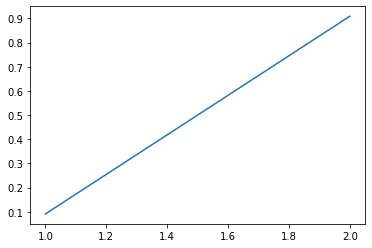

In [26]:
# PLOT THE RESULT

# X: number of infected nodes
# Y: probability

n = 2
beta = 5

p = np.zeros(n+1)

p[0] = 0
p[1] = 1/(2*beta+1)

for i in range(2,n):
    p[i] = (i-1)*(2*beta)/(2*beta+1)*(beta/(beta+1))**(i-2)/(beta+1)**2
    
p[n] = (2*beta)/(2*beta+1) * ((n-2)*(beta/(beta+1))**(n-2)/(beta+1)+(beta/(beta+1))**(n-2))

x = range(n+1)

plt.plot(x[1:n+1],p[1:n+1])
plt.show()

**Limits**:
- $\beta \to 0^+$: $p_1 \to 1$;
- $\beta \to +\infty$: $p_n \to 1$.

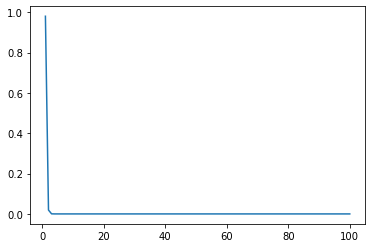

In [30]:
n = 100
beta = 0.01

p = np.zeros(n+1)

p[0] = 0
p[1] = 1/(2*beta+1)

for i in range(2,n):
    p[i] = (i-1)*(2*beta)/(2*beta+1)*(beta/(beta+1))**(i-2)/(beta+1)**2
    
p[n] = (2*beta)/(2*beta+1) * ((n-2)*(beta/(beta+1))**(n-2)/(beta+1)+(beta/(beta+1))**(n-2))

x = range(n+1)

plt.plot(x[1:n+1],p[1:n+1])
plt.show()

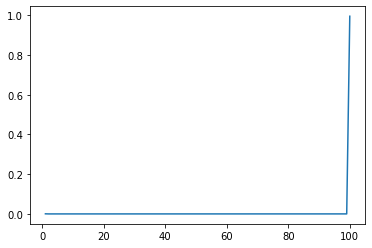

In [31]:
n = 100
beta = 1000

p = np.zeros(n+1)

p[0] = 0
p[1] = 1/(2*beta+1)

for i in range(2,n):
    p[i] = (i-1)*(2*beta)/(2*beta+1)*(beta/(beta+1))**(i-2)/(beta+1)**2
    
p[n] = (2*beta)/(2*beta+1) * ((n-2)*(beta/(beta+1))**(n-2)/(beta+1)+(beta/(beta+1))**(n-2))

x = range(n+1)

plt.plot(x[1:n+1],p[1:n+1])
plt.show()

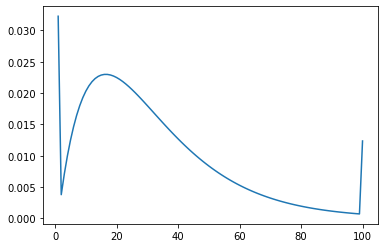

In [32]:
n = 100
beta = 15

p = np.zeros(n+1)

p[0] = 0
p[1] = 1/(2*beta+1)

for i in range(2,n):
    p[i] = (i-1)*(2*beta)/(2*beta+1)*(beta/(beta+1))**(i-2)/(beta+1)**2
    
p[n] = (2*beta)/(2*beta+1) * ((n-2)*(beta/(beta+1))**(n-2)/(beta+1)+(beta/(beta+1))**(n-2))

x = range(n+1)

plt.plot(x[1:n+1],p[1:n+1])
plt.show()